In [ ]:
import json
import pandas as pd
import numpy as np

def parse_json_file(file_path):
    """
    Parse JSON file and organize data by topic.
    
    Parameters:
    file_path (str): Path to the JSON file
    
    Returns:
    dict: Data organized by topic
    """
    data_by_topic = {}  # Dictionary to store data organised by topic

    with open(file_path, 'r') as file:
        for line in file:
            try:
                # Parse each JSON object
                obj = json.loads(line.strip())
                
                # Get the topic name from the JSON object
                topic_name = obj.get("topic_name")
                
                # Initialize the list for this topic if it doesn't exist
                if topic_name not in data_by_topic:
                    data_by_topic[topic_name] = []
                    
                # Append the data to the appropriate topic list
                data_by_topic[topic_name].append(obj)

            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")

    # Print summary of data
    print("\nData organized by topic:")
    for topic, items in data_by_topic.items():
        print(f"{topic}: {len(items)} entries")

    return data_by_topic


file_path =  # Replace with your file path
data_by_topic = parse_json_file(file_path)

aruco_path =  # Replace with your file path

print("\nData organized by topic:")
for topic, items in data_by_topic.items():
    print(f"{topic}: {len(items)} entries")


Data organized by topic:
/true_wheel_speeds: 276 entries
/aruco: 618 entries
/est_pose: 571 entries
/wheel_speeds_cmd: 571 entries
/lidar: 22 entries

Data organized by topic:
/true_wheel_speeds: 276 entries
/aruco: 618 entries
/est_pose: 571 entries
/wheel_speeds_cmd: 571 entries
/lidar: 22 entries


In [5]:
# Inspect structure of items in topics
print(data_by_topic.keys())

topic_to_check = '/groundtruth'

if topic_to_check in data_by_topic:
    print(f"Topic '{topic_to_check}' exists!")    
    simulation_flag = True
else:
    print(f"Topic '{topic_to_check}' does not exist.")
    simulation_flag = False

dict_keys(['/true_wheel_speeds', '/aruco', '/est_pose', '/wheel_speeds_cmd', '/lidar'])
Topic '/groundtruth' does not exist.


In [6]:
import math

# To extract heading from quaternion (orientation)
def quaternion_to_euler(w, x, y, z):
    """Convert quaternion (w, x, y, z) to Euler angles (roll, pitch, yaw)."""
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = math.atan2(t0, t1)
    
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch_y = math.asin(t2)
    
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw_z = math.atan2(t3, t4)
    
    return roll_x, pitch_y, yaw_z

# For /est_pose (same structure as /aruco)
est_pose_timestamps = [item['message']['header']['stamp'] for item in data_by_topic['/est_pose']]
est_pose_northings = [item['message']['pose']['position']['x'] for item in data_by_topic['/est_pose']]
est_pose_eastings = [item['message']['pose']['position']['y'] for item in data_by_topic['/est_pose']]
est_pose_headings = [(quaternion_to_euler(item['message']['pose']['orientation']['w'], 
                                         item['message']['pose']['orientation']['x'], 
                                         item['message']['pose']['orientation']['y'], 
                                         item['message']['pose']['orientation']['z'])[2])% (2*np.pi)
                     for item in data_by_topic['/est_pose']]


# Wheel speeds
true_wheel_timestamps = [item['message']['header']['stamp'] for item in data_by_topic['/true_wheel_speeds']]
true_wheel_speeds = [item['message']['vector']['x'] for item in data_by_topic['/true_wheel_speeds']]
wheel_speeds_timestamps = [item['message']['header']['stamp'] for item in data_by_topic['/wheel_speeds_cmd']]
wheel_speeds_cmd = [item['message']['vector']['x'] for item in data_by_topic['/wheel_speeds_cmd']]

# Extract ArUco data northings, eastings, and heading
aruco_timestamps = [(item['message']['header']['stamp']) for item in data_by_topic['/aruco']]
aruco_northings = [item['message']['pose']['position']['x'] for item in data_by_topic['/aruco']]
aruco_eastings = [item['message']['pose']['position']['y'] for item in data_by_topic['/aruco']]

aruco_headings = [(quaternion_to_euler(item['message']['pose']['orientation']['w'], 
                                      item['message']['pose']['orientation']['x'], 
                                      item['message']['pose']['orientation']['y'], 
                                      item['message']['pose']['orientation']['z'])[2]) % (2*np.pi)
                  for item in data_by_topic['/aruco']]

# Extract simulation ground truth data northings, eastings
if simulation_flag == True:
    groundtruth_timestamps = [float(item['timestamp']) for item in data_by_topic['/groundtruth']]
    groundtruth_northings = [item['message']['position']['x'] for item in data_by_topic['/groundtruth']]
    groundtruth_eastings = [item['message']['position']['y'] for item in data_by_topic['/groundtruth']]
    
    groundtruth_headings = [(quaternion_to_euler(item['message']['orientation']['w'], 
                                                item['message']['orientation']['x'], 
                                                item['message']['orientation']['y'], 
                                                item['message']['orientation']['z'])[2]) % (2*np.pi)  # Extract the yaw (heading)
                            for item in data_by_topic['/groundtruth']
    ]

else:
    df = pd.read_csv(aruco_path)    
    start_time = np.min(est_pose_timestamps)
    end_time = np.max(est_pose_timestamps)
    filtered_data = df.loc[(df['epoch [s]'] >= start_time) & (df['epoch [s]'] <= end_time)]

    groundtruth_timestamps = filtered_data['epoch [s]']
    groundtruth_northings = filtered_data['x [m]']
    groundtruth_eastings = filtered_data['y [m]']
    groundtruth_headings = np.deg2rad(filtered_data['yaw [deg]'] % (360))

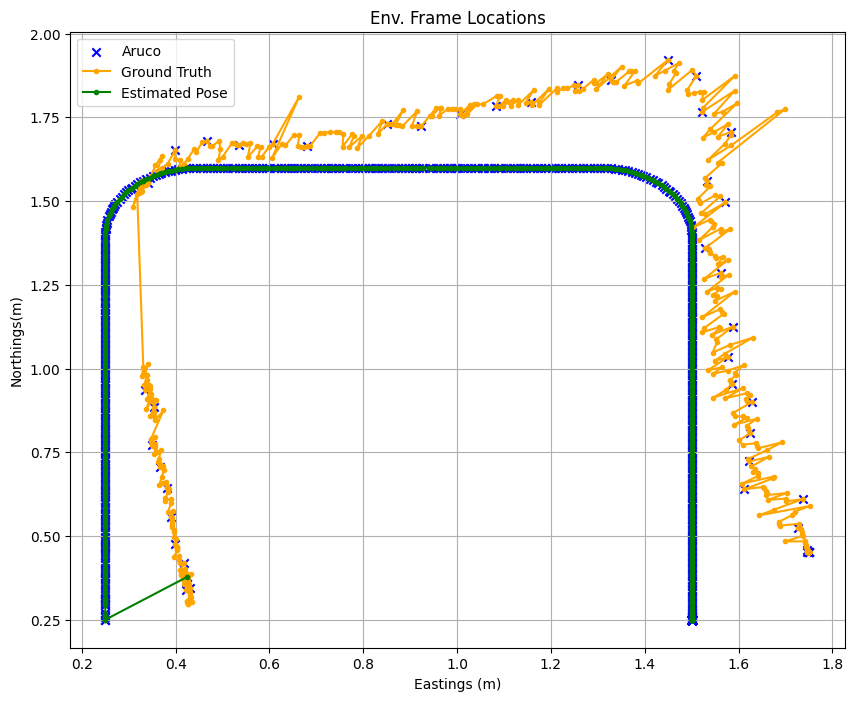

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 8))
plt.scatter(aruco_eastings, aruco_northings, label="Aruco", marker="x", color="blue")
plt.plot(groundtruth_eastings, groundtruth_northings, label="Ground Truth", marker=".", color="orange")
plt.plot(est_pose_eastings, est_pose_northings, label="Estimated Pose", marker=".", color="green")
# plt.plot(lidar_eastings, lidar_northings, label="Lidar", marker="s")

plt.xlabel("Eastings (m)")
plt.ylabel("Northings(m)")
plt.legend()
plt.title("Env. Frame Locations")
plt.grid()
plt.show()

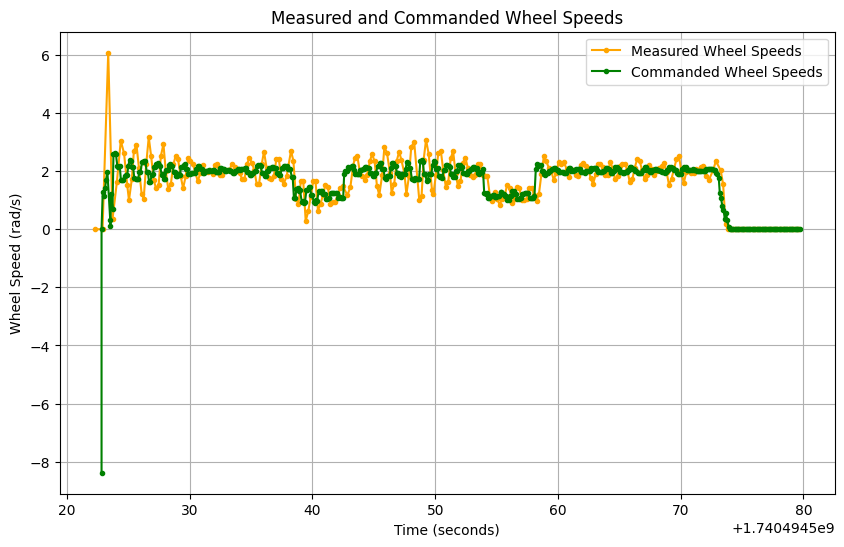

In [11]:
# Extract timestamps fpr wheel speeds
true_wheel_speeds_timestamps = [entry['timestamp'] for entry in data_by_topic['/true_wheel_speeds']]
wheel_speeds_cmd_timestamps = [entry['timestamp'] for entry in data_by_topic['/wheel_speeds_cmd']]

# Ensure timestamps are float
true_wheel_speeds_timestamps = [float(ts) for ts in true_wheel_speeds_timestamps]
wheel_speeds_cmd_timestamps = [float(ts) for ts in wheel_speeds_cmd_timestamps]

plt.figure(figsize=(10, 6))

plt.plot(true_wheel_speeds_timestamps, true_wheel_speeds, label="Measured Wheel Speeds", marker=".", color="orange")
plt.plot(wheel_speeds_cmd_timestamps, wheel_speeds_cmd, label="Commanded Wheel Speeds", marker=".", color="green")

plt.xlabel("Time (seconds)")
plt.ylabel("Wheel Speed (rad/s)")
plt.legend()
plt.title("Measured and Commanded Wheel Speeds")
plt.grid()
plt.show()

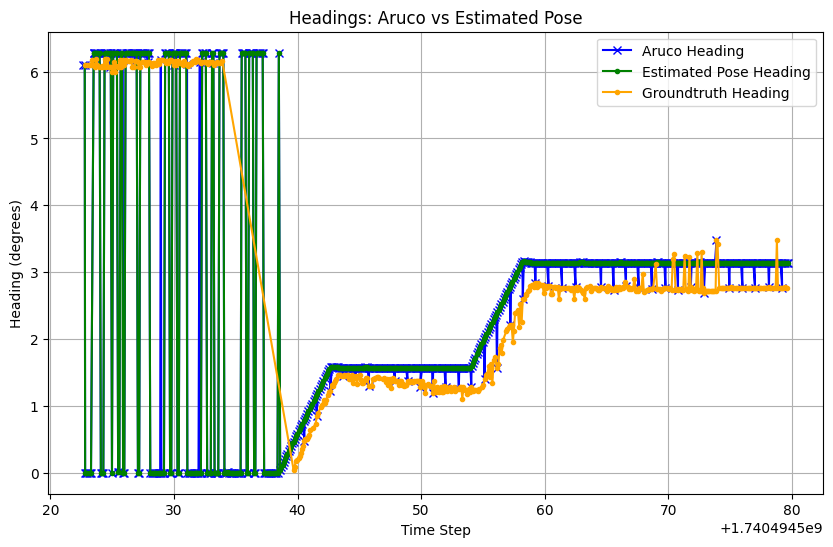

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(aruco_timestamps, aruco_headings, label="Aruco Heading", marker="x", color="blue")
plt.plot(est_pose_timestamps, est_pose_headings, label="Estimated Pose Heading", marker=".", color="green")
plt.plot(groundtruth_timestamps, groundtruth_headings, label="Groundtruth Heading", marker=".", color="orange")

plt.xlabel("Time Step")
plt.ylabel("Heading (degrees)")
plt.legend()
plt.title("Headings: Aruco vs Estimated Pose")
plt.grid()
plt.show()